In [1]:
import numpy as np

import qiskit
from qiskit import IBMQ, QuantumRegister, ClassicalRegister, assemble
from qiskit.extensions import UnitaryGate
from qiskit.providers.aer import PulseSimulator, Aer, QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.test.mock import FakeArmonk
from qiskit.tools import job_monitor
from src.helper import qutip_ham_converter
from src.qoc_instruction_schedule_map import QOCInstructionScheduleMap
from src.QutipOptimizer import QutipOptimizer

In [2]:
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
real_armonk_backend = provider.get_backend('ibmq_armonk')
fake_armonk_backend = FakeArmonk()

In [3]:
#set armonk sim parameters
omegad0 = 31919806.545849085

# omegad0 = 0.07
getattr(fake_armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = omegad0
freq_est = 4.97445401836326e9
fake_armonk_backend.configuration().qubit_freq_est=[freq_est]
getattr(fake_armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est
fake_armonk_model = PulseSystemModel.from_backend(fake_armonk_backend)

In [4]:
# Instantiate grape optimizer with armonk backend
grape_optimizer = QutipOptimizer(fake_armonk_backend, n_ts=320)

# Create new QOCInstructionScheduleMap with this optimizer
def_inst = ['measure']
builtin_instructions = fake_armonk_backend.defaults().instruction_schedule_map
grape_inst_map = QOCInstructionScheduleMap.from_inst_map(grape_optimizer, builtin_instructions,
                                                         default_inst=def_inst)


In [5]:
# choose random phi for u3 rotation
phi = np.random.random_sample(1)
theta = np.random.random_sample(1)
lamb = np.random.random_sample(1)
phi = phi[0] * np.pi
phi = np.pi

In [6]:
# create circuit
q = QuantumRegister(1)
c = ClassicalRegister(1)
circ = qiskit.QuantumCircuit(q, c)
# add an x gate using u3
# circ.x(q)
# circ.h(q)
circ.u3(phi,0,phi, q)
# circ.u3(theta,phi,lamb, q)
# add measurement pulse
circ.measure([0],[0])

In [7]:
# construct the schedule from the circuit using the grape instruction_schedule_map
grape_schedule = qiskit.schedule(circ, inst_map = grape_inst_map,
                        meas_map = fake_armonk_backend.configuration().meas_map)

gate hit


In [8]:
# now compare to the default
default_schedule = qiskit.schedule(circ, inst_map = builtin_instructions,
                        meas_map = fake_armonk_backend.configuration().meas_map)

changed instruction to instruction.name


In [9]:
grape_schedule.duration
default_schedule.duration

17280

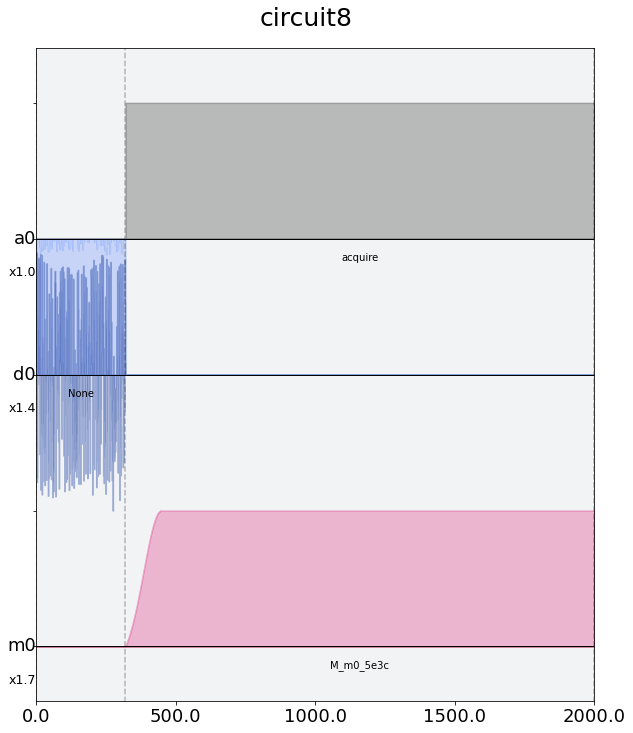

In [10]:
grape_schedule.draw(plot_range=[0,2000], label=True)

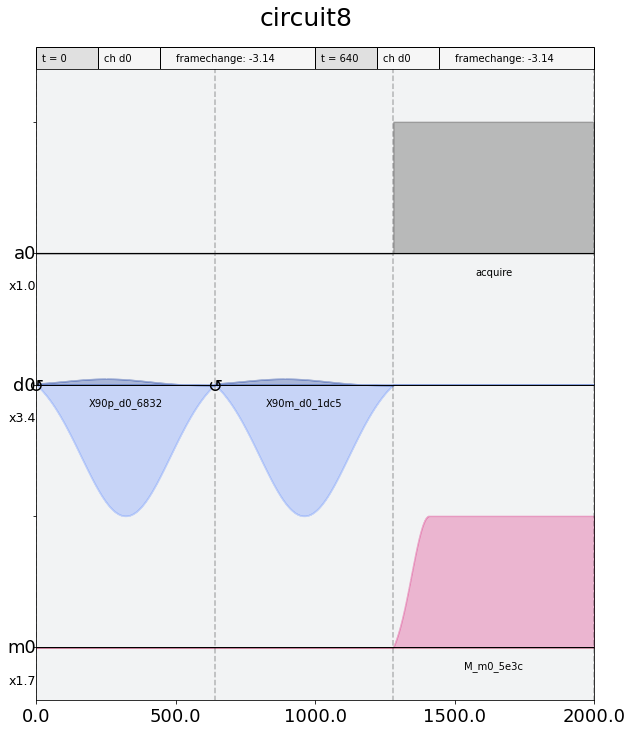

In [11]:
default_schedule.draw(plot_range=[0,2000], label=True)
# grape_schedule.draw(label=True, scaling=0.8)

In [12]:
# assemble qobj for job submission
backend_sim = PulseSimulator(configuration=fake_armonk_backend.configuration)

grape_qobj = assemble(grape_schedule,
                      backend=backend_sim,
                      qubit_lo_freq=[freq_est],
                      meas_level=2,
                      meas_return='single',
                      shots=1024)

default_qobj = assemble(default_schedule,
                      backend=backend_sim,
                      qubit_lo_freq=[freq_est],
                      meas_level=2,
                      meas_return='single',
                      shots=1024)

In [13]:
sim_result = backend_sim.run(grape_qobj, fake_armonk_model).result()
def_sim_result = backend_sim.run(default_qobj, fake_armonk_model).result()
# sim_result.get_counts()

In [14]:
noise_model = NoiseModel()
noise_model.add_basis_gates(['unitary'])
ideal_job = qiskit.execute(circ, QasmSimulator(),
                           basis_gates=noise_model.basis_gates)
# ideal_job.result().get_counts()



In [15]:
num_shots = 4096

In [16]:
armonk_qobj = assemble(grape_schedule,
                      backend=real_armonk_backend,
                      qubit_lo_freq=[freq_est],
                      meas_level=2,
                      meas_return='single',
                      shots=num_shots)
real_job = real_armonk_backend.run(armonk_qobj)
job_id = real_job._job_id

In [17]:
def_armonk_qobj = assemble(default_schedule,
                      backend=real_armonk_backend,
                      qubit_lo_freq=[freq_est],
                      meas_level=2,
                      meas_return='single',
                      shots=num_shots)
def_real_job = real_armonk_backend.run(def_armonk_qobj)
def_job_id = def_real_job._job_id

In [18]:

def_job = real_armonk_backend.retrieve_job(def_job_id)
job_monitor(def_job)
# def_job.result().get_counts()

job = real_armonk_backend.retrieve_job(job_id)
job_monitor(job)
# job.result().get_counts()

Job Status: job has successfully run
Job Status: job has successfully run


In [19]:
speedup = (default_schedule.duration - 16000) / (grape_schedule.duration - 16000)
def_acc = def_real_job.result().get_counts()['1'] / num_shots
grape_acc = real_job.result().get_counts()['1'] / num_shots
print('ideal (perfect gate) results: {}'.format(ideal_job.result().get_counts()))
print('simulated results (grape pulse): {}'.format(sim_result.get_counts()))
print('simulated results (builtin pulse): {}'.format(def_sim_result.get_counts()))
print('grape gate speedup factor: {}'.format(speedup))
print('hardware results (grape): {}'.format(real_job.result().get_counts()))
print('hardware results (default): {}'.format(def_real_job.result().get_counts()))
print('grape acc: {}, default acc: {}'.format(grape_acc, def_acc))
# print('Grape run on {} backend'.format(which_armonk))
# print('Used grape gate: {}'.format(not def_x))

ideal (perfect gate) results: {'1': 1024}
simulated results (grape pulse): {'1': 1024}
simulated results (builtin pulse): {'0': 20, '1': 1004}
grape gate speedup factor: 4.0
hardware results (grape): {'0': 418, '1': 3678}
hardware results (default): {'0': 339, '1': 3757}
grape acc: 0.89794921875, default acc: 0.917236328125
